In [1]:
import csv
import random
from utils import *
from collections import defaultdict, Counter
import os
import time
import tqdm
import itertools
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np

## generate SBMs and Erdos-Renyi graph

In [2]:
class SBMGraphStream():
    '''
    The class of Graph Stream from the stochastic block model
    ----- Parameters -----
    # n_vertex: the number of vertices in the graph
    # p_intra: the probability for + edge (u,v) for the same cluster
    # p_inter: the probability for + edge (u,v) for different clusters
    # k_cluster: number of clusters in the clustering
    ----- Methods ----
    # read_next_edge(): read the next edge and move the index +1
    ----- Representation ----
    The graph is representation with an indexed array of vertices and a dictionary with (u_i, u_j): labels
    '''
    
    def __init__(self, n_vertex, p_intra=0.8, p_inter=0.2, k_cluster=7):
        '''
        :param n_vertex: the the number of vertices in the graph
        '''
        self.n_vertex = n_vertex
        self.p_intra = p_intra
        self.p_inter = p_inter
        self.k_cluster = k_cluster
        
        # initialize the vertex set and the cluster labels
        self.vertex_set = np.array([self.n_vertex])
        num_v_per_cluster = n_vertex//self.k_cluster
        n_residual = n_vertex % num_v_per_cluster
        cluster_labels_list = []
        for i_cluster in range(k_cluster):
            cluster_labels_list.append(i_cluster*np.ones([num_v_per_cluster]))
        if n_residual!=0:
            cluster_labels_list.append((k_cluster-1)*np.ones([n_residual]))
        # collect them as a 1-d array
        self.cluster_labels = np.reshape(np.hstack(cluster_labels_list).astype(int), [-1])
        # initialize the edges -- using +1 and -1 to represent the edge labels
        # also compute the cost
        self.cc_cost = 0
        self.edge_dict = {}
        for u_i in tqdm.tqdm(range(self.n_vertex)):
            for u_j in np.arange(u_i+1, self.n_vertex):
                if self.cluster_labels[u_i] == self.cluster_labels[u_j]:
                    if np.random.rand() <= p_intra:
                        self.edge_dict[(u_i,u_j)] = 1
                    else:
                        self.edge_dict[(u_i,u_j)] = -1
                        self.cc_cost = self.cc_cost + 1
                else:
                    if np.random.rand() <= p_inter:
                        self.edge_dict[(u_i,u_j)] = 1
                        self.cc_cost = self.cc_cost + 1
                    else:
                        self.edge_dict[(u_i,u_j)] = -1
        # randomize the order of edge arrival
        self.edge_names = list(self.edge_dict.keys())
        random.shuffle(self.edge_names)
        self.num_edges = len(self.edge_names)
        # maintain a pointer of the number of edges
        self.current_stream_ind = 0
        
    def read_next_edge(self):
        
        this_edge_name = self.edge_names[self.current_stream_ind]
        this_edge_label = self.edge_dict[this_edge_name]
        self.current_stream_ind = self.current_stream_ind + 1
        if self.current_stream_ind>=self.num_edges-1:
            return None, None
        
        return this_edge_name, this_edge_label
    
    def write_edges(self, write_path=None):
        if not write_path:
            raise ValueError('the writing path has to be specified!')
        file_name = 'SBM_n='+str(self.n_vertex)+'_p='+str(self.p_intra)+'_k=' + str(self.k_cluster) +'.csv'
        with open(os.path.join(write_path, file_name), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            for edge in self.edge_dict:
                if self.edge_dict[edge]>0:
                    writer.writerow([f'{edge[0]} {edge[1]}'])
    def reset_index(self):
        '''
        reset the pointer
        '''
        self.current_stream_ind = 0

In [3]:
sbm_graph_stream = SBMGraphStream(n_vertex=200,p_intra=0.95, p_inter=0.05, k_cluster=4)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 7973.81it/s]


In [4]:
sbm_graph_stream.write_edges(write_path='../data/')

## The functions that implements our algorithm

In [5]:
def sparsity_test(target_vertex, current_graph, eps=0.2):
    current_num_vertex = len(current_graph)+1
    num_sample = max((int)(np.log(current_num_vertex)/eps), 20)
    num_diff_test_sample = max((int)(np.log(current_num_vertex)/eps), 20)
    if current_graph[target_vertex].degree == 0:
        return True
    num_neighbor_diff = 0
    for comp_vertex in current_graph[target_vertex].getRandom(i=num_diff_test_sample):
        if current_graph[comp_vertex].degree>(1+eps)*current_graph[target_vertex].degree:
            num_neighbor_diff = num_neighbor_diff + 1
            continue
        total_diff = 0
        for test_vertex in current_graph[target_vertex].getRandom(i=num_sample):
            if test_vertex not in current_graph[comp_vertex]:
                total_diff = total_diff + 1
        if (total_diff>=eps*num_diff_test_sample):
            num_neighbor_diff = num_neighbor_diff + 1
    if num_neighbor_diff >=eps*num_diff_test_sample:
        return True
    else:
        return False

In [6]:
def test_sparse_vertex(current_graph, global_graph, eps=0.2):
    # sample log n neighbors for each vertex
    sparse_vertex_list = []
    for this_vertex in current_graph:
        if sparsity_test(this_vertex, global_graph, eps=eps):
            sparse_vertex_list.append(this_vertex)
        
    # return the list of sparse vertices
    return sparse_vertex_list

In [7]:
def sparse_dense_decop(current_graph, global_graph, eps=0.2):
    current_num_vertex = len(global_graph)+1
    # the returned clusters
    SDD_clustering = {}
    # check sparse vertices
    tic = time.time()
    current_sparse_vertice = test_sparse_vertex(current_graph, global_graph, eps=eps)
    for sparse_vertex in current_sparse_vertice:
        SDD_clustering[sparse_vertex]=sparse_vertex
    # print('The time for sparsity testing is ', time.time()-tic)
    # sample from the dense vertices
    dense_subgraph = {vertex: current_graph[vertex] 
                      for vertex in current_graph if vertex not in current_sparse_vertice}
    anchor_vertex_dict = {}
    # tic = time.time()
    for this_vertex in dense_subgraph:
        # rejection sampling
        dense_sample_prob = max((np.log(current_num_vertex))/(eps*dense_subgraph[this_vertex].degree), 0.02)
        if dense_sample_prob>=np.random.uniform(low=0.0, high=1.0):
            anchor_vertex_dict[this_vertex] = dense_subgraph[this_vertex]
    # print('The time for indexing the subgraph ', time.time()-tic)
    # recursively form almost-cliques
    num_sample = max((int)(5*np.log(current_num_vertex)), 20)
    AC_dict = {}
    # maintain a list of covered vertices
    # tic = time.time()
    covered_AC_vertex = []
    for this_anchor_vertex in anchor_vertex_dict.keys():
        if this_anchor_vertex in covered_AC_vertex:
            continue
        AC_dict[this_anchor_vertex] = {}
        AC_dict[this_anchor_vertex]['AC'] = []
        AC_dict[this_anchor_vertex]['size'] = 1
        AC_dict[this_anchor_vertex]['counter'] = 0
        SDD_clustering[this_anchor_vertex] = this_anchor_vertex  # assign to the cluster represented by self
        covered_AC_vertex.append(this_anchor_vertex)
        anchor_neighbor_samples = list(anchor_vertex_dict[this_anchor_vertex].getRandom(i=num_sample))
        for candidate_vertex in dense_subgraph[this_anchor_vertex]:
            if (candidate_vertex in current_sparse_vertice) or (candidate_vertex in covered_AC_vertex):
                continue
            # test whether their symmetric difference is large enough
            # the intersections of the neighbor
            total_diff = 0
            for anchor_neighbor in anchor_neighbor_samples:
                if anchor_neighbor not in list(dense_subgraph[candidate_vertex]):
                    total_diff = total_diff + 1
            if (total_diff<=1.5*eps*num_sample):
                AC_dict[this_anchor_vertex]['AC'].append(candidate_vertex)
                AC_dict[this_anchor_vertex]['size'] += 1
                SDD_clustering[candidate_vertex] = this_anchor_vertex # assign the candidate vertex to the anchor
                covered_AC_vertex.append(candidate_vertex)
            # this line is for debugging purpose -- remove later
            else:
                pass
    # add codes to add vertices to the almost-cliques
    # print('The time for forming almost-cliques is ', time.time()-tic)
    # merge undecided vertices to the almost-cliques
    num_diff_test_sample = max((int)(2*np.log(current_num_vertex)), 20)
    # pull the undecided vertices
    undecided_AC_vertices = []
    for dense_vertex in dense_subgraph.keys():
        if dense_vertex not in SDD_clustering.keys():
            undecided_AC_vertices.append(dense_vertex)
    for und_vertex in undecided_AC_vertices:
        und_v_sampled_neighbors = list(dense_subgraph[und_vertex].getRandom(i=num_diff_test_sample))
        neighbor_AC_names = []
        for merge_test_vertex in und_v_sampled_neighbors:
            if merge_test_vertex not in SDD_clustering:
                continue
            neighbor_AC_names.append(SDD_clustering[merge_test_vertex])
        if not neighbor_AC_names:
            current_sparse_vertice.append(und_vertex)
            SDD_clustering[und_vertex] = und_vertex
            continue
        AC_counts = Counter(neighbor_AC_names)
        most_common_AC, most_common_AC_freq = AC_counts.most_common(1)[0]
#         except:
#             print(neighbor_AC_names)
#             raise ValueError('Something wrong just happened!')
        if (most_common_AC_freq>=(1-2*eps)*num_diff_test_sample) and (most_common_AC in AC_dict):
            SDD_clustering[und_vertex] = most_common_AC
            AC_dict[most_common_AC]['AC'].append(und_vertex)
            AC_dict[most_common_AC]['size'] += 1
        else:
            # this line should not happen in theory, but we need to handle singleton cases in practice
            current_sparse_vertice.append(und_vertex)
            SDD_clustering[und_vertex] = und_vertex
    
    
    return current_sparse_vertice, AC_dict, SDD_clustering, anchor_vertex_dict

In [8]:
def singleton_cluster_alg(current_graph):
    return {vertex: vertex for vertex in current_graph}

## The implementation of dynamic algorithms

In [9]:
def extract_induced_subgraph(current_graph, target_vertex):
    num_vertex = len(current_graph)+1
    neighbor_of_target = list(current_graph[target_vertex]) + [target_vertex]
    num_sample = min(max((int)(2*np.log(num_vertex)), 20), len(neighbor_of_target))
    induced_subgraph = {}
    valid_neighbor_vertices = []
    for neighbor_vertex in neighbor_of_target:
        this_neighbor_list = list(set(current_graph[neighbor_vertex].a).intersection(set(neighbor_of_target)))
        if len(this_neighbor_list)>=0.3*current_graph[neighbor_vertex].degree:
            valid_neighbor_vertices.append(neighbor_vertex)
    for neighbor_vertex in valid_neighbor_vertices:
        # let's pretend that intersection happens in O(1) time
        this_new_neighbor_list = list(set(current_graph[neighbor_vertex].a).intersection(set(valid_neighbor_vertices)))
        induced_subgraph[neighbor_vertex] = OptList(a=this_new_neighbor_list,
                                                    d=this_new_neighbor_list, 
                                                    degree=current_graph[neighbor_vertex].degree)
        # estimation of the cost
#         sample_vertex_in_subgraph = random.sample(neighbor_of_target, num_sample)
#         count_degree = 0
#         for sampled_vertex in sample_vertex_in_subgraph:
#             if sampled_vertex in current_graph[neighbor_vertex]:
#                 count_degree = count_degree + 1
#         est_degree = count_degree*len(neighbor_of_target)/num_sample
#         induced_subgraph[neighbor_vertex] = OptList(a=this_neighbor_list, d=this_neighbor_list, degree=est_degree)
    
    return induced_subgraph

In [10]:
def dynamic_sparse_dense_decomp(subgraph, global_graph, global_SDD, 
                                global_sparse_vertices, global_AC_dict, target_vertex, eps=0.2):
    '''
    params: 
    subgraph: the subgraph that we want to run SDD on. Note that this is *not* the exact N(u) since we
                filter out all the vertices that are not dense locally
    global_graph: the global graph represented by the dictionary of OptList()
    global_SDD: the sparse-dense decomposition we maintain for the global graph (clustering representation)
    global_sparse_vertices: the list of sparse vertices
    target_vertex: we need this information to run the sparsity tests for all vertices in N(u)
    '''
    num_vertex = len(global_graph)
    # ************** Formation of Almost-cliques *******************
    subgraph_sparse_vertex_list,subgraph_AC_dict, subgraph_SDD_clustering, anchor_vertex_dict = sparse_dense_decop(
        subgraph, global_graph, eps=eps)
    # update the almost-cliques and the list of sparse vertices
    # this test should not be necessary in theory
    # just to avoid weird bugs
    new_almost_cliques = {}
    for this_anchor_vertex in subgraph_AC_dict:
        this_AC_anchor_dict = subgraph_AC_dict[this_anchor_vertex]
        new_almost_cliques[this_anchor_vertex] = {}
        new_almost_cliques[this_anchor_vertex]['AC'] = []
        new_almost_cliques[this_anchor_vertex]['size'] = 1
        new_almost_cliques[this_anchor_vertex]['counter'] = 0
        this_AC_anchor_neighbors = this_AC_anchor_dict['AC']
        this_AC_size = this_AC_anchor_dict['size']
        num_invalid_vertex = 0
        for neighbor_vertex in this_AC_anchor_neighbors:
            if (global_graph[neighbor_vertex].degree 
                >= (1+2*eps)*this_AC_size) or (neighbor_vertex not in global_sparse_vertices):
                num_invalid_vertex += 1
                this_AC_anchor_dict['AC'].remove(neighbor_vertex)
                this_AC_anchor_dict['size'] = this_AC_anchor_dict['size'] - 1
            elif neighbor_vertex in global_sparse_vertices:
                global_sparse_vertices.remove(neighbor_vertex)
            else:
                print('Something strange happened; vertex', neighbor_vertex,'should be a globally sparse vertex.')
                pass
        # dismantle the AC if too many members have been lost
        if num_invalid_vertex>=2*eps*this_AC_size:
            global_sparse_vertices.append(this_AC_anchor_dict)
            for member_vertex in this_AC_anchor_neighbors:
                global_sparse_vertices.append(member_vertex)
        # add new vertices
        num_sample_from_AC = max((int)(3*np.log(num_vertex)), 20)
        num_sample_tests_AC = max((int)(3*np.log(num_vertex)/eps), 20)
        if num_sample_from_AC>len(this_AC_anchor_neighbors):
            sample_AC_vertex_list = this_AC_anchor_neighbors[:]
        else:
            sample_AC_vertex_list = random.sample(this_AC_anchor_neighbors, num_sample_from_AC)
        if num_sample_tests_AC>len(this_AC_anchor_neighbors):
            sampled_T_set = this_AC_anchor_neighbors[:]
        else:
            sampled_T_set = random.sample(this_AC_anchor_neighbors, num_sample_tests_AC)
        # find the neighbors of these vertices
        for sampled_AC_vertex in sample_AC_vertex_list:
            neighbors_of_the_sampled_vertex = global_graph[sampled_AC_vertex]
            for candidate_vertex in neighbors_of_the_sampled_vertex:
                total_agreement = 0
                for sample_T_vertex in sampled_T_set:
                    if sample_T_vertex in global_graph[candidate_vertex]:
                        total_agreement = total_agreement +1
                if (total_agreement>=(1-2*eps)*num_sample_tests_AC):
                    if (global_graph[candidate_vertex].degree>=(1-2*eps)*this_AC_size):
                        if (global_graph[candidate_vertex].degree<=(1+2*eps)*this_AC_size):
                            this_AC_anchor_dict['AC'].append(candidate_vertex)
                            this_AC_anchor_dict['size'] += 1
        new_almost_cliques[this_anchor_vertex]['AC'] = this_AC_anchor_dict['AC']
        new_almost_cliques[this_anchor_vertex]['size'] = this_AC_anchor_dict['size']
    # merge the almost-cliques with the existing SDD
    # the sparse vertex list has already been updated
    for new_dense_anchor in new_almost_cliques:
        global_AC_dict[new_dense_anchor] = new_almost_cliques[new_dense_anchor]
        for AC_member in new_almost_cliques[new_dense_anchor]['AC']:
            global_SDD[AC_member] = new_dense_anchor
    # ******************** Removing Vertices from Almost-cliques ***********************
    neighbors_of_the_target_vertex = global_graph[target_vertex]
    for possible_candidate_sparse in neighbors_of_the_target_vertex:
        if sparsity_test(possible_candidate_sparse, global_graph, eps=eps):
            if possible_candidate_sparse in global_sparse_vertices:
                continue
            # add to the list of sparse vertices
            global_sparse_vertices.append(possible_candidate_sparse)
            global_SDD[possible_candidate_sparse] = possible_candidate_sparse
            # remove from almost-cliques
            AC_anchor = global_SDD[possible_candidate_sparse]
            if AC_anchor not in global_AC_dict:
                global_sparse_vertices.append(AC_anchor)
                global_SDD[AC_anchor] = AC_anchor
                continue
            if global_AC_dict[AC_anchor]['size'] == 1:
                global_sparse_vertices.append(AC_anchor)
                global_SDD[AC_anchor] = AC_anchor
                del global_AC_dict[AC_anchor]
                continue
            if possible_candidate_sparse == AC_anchor:
                first_other_anchor = global_AC_dict[AC_anchor]['AC'][0]
                global_AC_dict[first_other_anchor] = {}
                global_AC_dict[first_other_anchor]['AC'] = []
                global_AC_dict[first_other_anchor]['size'] = global_AC_dict[AC_anchor]['size'] - 1
                global_AC_dict[first_other_anchor]['counter'] = global_AC_dict[AC_anchor]['counter']
                for member in global_AC_dict[AC_anchor]['AC']:
                    if member!=first_other_anchor:
                        global_AC_dict[first_other_anchor]['AC'].append(member)
                global_sparse_vertices.append(possible_candidate_sparse)
                global_SDD[possible_candidate_sparse] = possible_candidate_sparse
                continue
            global_AC_dict[AC_anchor]['AC'].remove(possible_candidate_sparse)
#             except:
#                 print('++++++++++++++++++++++++++++')
#                 print(possible_candidate_sparse)
#                 print(global_SDD[possible_candidate_sparse])
#                 print(global_AC_dict[AC_anchor]['size'])
#                 print(global_AC_dict[AC_anchor]['AC'])
#                 raise ValueError('Something wrong just happened!')
            global_AC_dict[AC_anchor]['counter'] = global_AC_dict[AC_anchor]['counter'] + 1
            # **************** Dismantle almost-cliques if they loss too many vertices
            if global_AC_dict[AC_anchor]['counter']>=1.2*eps*global_AC_dict[AC_anchor]['size']:
                global_sparse_vertices.append(AC_anchor)
                global_SDD[AC_anchor] = AC_anchor
                for past_dense_vertex in global_AC_dict[AC_anchor]['AC']:
                    global_sparse_vertices.append(past_dense_vertex)
                    global_SDD[past_dense_vertex] = past_dense_vertex
                del global_AC_dict[AC_anchor]
    
    return global_sparse_vertices, global_AC_dict, global_SDD, anchor_vertex_dict

## Read the edges and maintain clustering

In [11]:
graph_file_name="../data/SBM_n=200_p=0.95_k=4.csv"
# graph_file_name= "../data/email-Eu-core.csv"

In [12]:
adjacency_list, edge_list = create_graph_from_csv(graph_file_name)

In [13]:
'''
TODO

See if functions are doable

'''




def simulate_random_edge_update(current_graph, current_edge_list, available_edge_list, prob_del):
    
    #Toss a coin for deletion
    if np.random.binomial(1,prob_del) and current_edge_list:
        edge_to_delete_idx = np.random.choice(len(current_edge_list))
        edge_to_delete = current_edge_list[edge_to_delete_idx]
        
        u = edge_to_delete[0]
        v = edge_to_delete[1]
        current_graph[u].remove(v)
        current_graph[v].remove(u)
        
        available_edge_list.extend([edge_to_delete])
        current_edge_list.pop(edge_to_delete_idx)
        
        return current_graph, current_edge_list, available_edge_list, u, v
    
    #Else we add edge
    else:
        
        #Check if we have edges to add
        if available_edge_list:
            current_edge_list.append(available_edge_list[0])
            u = available_edge_list[0][0]
            v = available_edge_list[0][1]
            if u not in current_graph.keys():
                current_graph[u] = OptList()
            current_graph[u].insert(v)
            if v not in current_graph.keys():
                current_graph[v] = OptList()
            current_graph[v].insert(u)
            available_edge_list.pop(0)
            
            return current_graph, current_edge_list, available_edge_list, u, v
            
        
        # We have run out of edges to insert so need to delete
        else:
            edge_to_delete_idx = np.random.choice(len(current_edge_list))
            edge_to_delete = current_edge_list[edge_to_delete_idx]

            u = edge_to_delete[0]
            v = edge_to_delete[1]
            current_graph[u].remove(v)
            current_graph[v].remove(u)

            available_edge_list.extend([edge_to_delete])
            current_edge_list.pop(edge_to_delete_idx)

            return current_graph, current_edge_list, available_edge_list, u, v

        
        

        
def simulate_edge_update_adversarial(current_graph, current_edge_list, edge_additions, edge_deletions, prob_del):
    
    '''
    Simulate edge updates to destroy clusters
    Ensure at least one of (edge_additions, edge_deletions) is non empty before calling
    '''
    
    u = None
    v = None
    
    if np.random.binomial(1,prob_del) and edge_deletions:
        idx = 0 
        for edge in edge_deletions: #Find the first edge we can delete
            if edge in current_edge_list:
                u = edge[0]
                v = edge[1]
                edge_to_delete_idx = current_edge_list.index([u,v])
                edge_to_delete = edge

                current_graph[u].remove(v)
                current_graph[v].remove(u)
                current_edge_list.pop(edge_to_delete_idx)
                edge_deletions = edge_deletions[idx+1:] 

                return current_graph, current_edge_list, edge_additions, edge_deletions, u, v
            else:
                idx += 1
        #All edges already deleted
        return current_graph, current_edge_list, edge_additions, [], u, v
    
    else:
        
        #Check if we have edges to add
        if edge_additions:
            idx = 0 
            for edge in edge_additions: #Find the first edge we can add
                if edge not in current_edge_list:
                    u = edge[0]
                    v = edge[1]
                    current_edge_list.append([u,v])
                    if u not in current_graph.keys():
                        current_graph[u] = OptList()
                    current_graph[u].insert(v)
                    if v not in current_graph.keys():
                        current_graph[v] = OptList()
                    current_graph[v].insert(u)
                    edge_additions = edge_additions[idx+1:]

                    return current_graph, current_edge_list, edge_additions, edge_deletions, u, v
                
                else:
                    idx += 1
            #All edges already added
            return current_graph, current_edge_list, [], edge_deletions, u, v
                
        # We have run out of edges to insert so need to delete
        else:
            idx = 0 
            for edge in edge_deletions: #Find the first edge we can delete
                if edge in current_edge_list:
                    u = edge[0]
                    v = edge[1]
                    edge_to_delete_idx = current_edge_list.index([u,v])
                    edge_to_delete = edge

                    current_graph[u].remove(v)
                    current_graph[v].remove(u)
                    current_edge_list.pop(edge_to_delete_idx)
                    edge_deletions = edge_deletions[idx+1:] 

                    return current_graph, current_edge_list, edge_additions, edge_deletions, u, v
                else:
                    idx += 1
            #All edges already deleted
            return current_graph, current_edge_list, edge_additions, [], u, v




def update_SDD_clustering(u, v, current_graph, SDD_clustering, current_sparse_vertex_list, almost_cliques, track_update_benckmark, track_update_num, eps_param):
    
    if u not in track_update_benckmark:
        track_update_benckmark[u] = current_graph[u].degree
    if v not in track_update_benckmark:
        track_update_benckmark[v] = current_graph[v].degree
    
    # update the tracking of the updates on u and v
    if u not in track_update_num:
        track_update_num[u] = 1
    else:
        track_update_num[u] = track_update_num[u] + 1
    if v not in track_update_num:
        track_update_num[v] = 1
    else:
        track_update_num[v] = track_update_num[v] + 1

    # SDD clustering
    # Maintain the original clustering -- if the newly added vertice are not in the SDD
    # then we assign singletons

    SDD_update_time = 0

    if u not in SDD_clustering:
        SDD_clustering[u] = u
    if v not in SDD_clustering:
        SDD_clustering[v] = v
    
    # The update step
    if (track_update_num[u]>max(2, eps_param*track_update_benckmark[u])):
        # tests
        current_subgraph = extract_induced_subgraph(current_graph, u)
        
        if not (len(current_subgraph) == 1 and (not list(current_subgraph[list(current_subgraph.keys())[0]]))):
        
            start_SDD = time.time()
            current_sparse_vertex_list, almost_cliques, SDD_clustering, anchor_vertex_dict = dynamic_sparse_dense_decomp(current_subgraph,
                                                                                                                         current_graph, 
                                                                                                                         SDD_clustering,
                                                                                                                         current_sparse_vertex_list,
                                                                                                                         almost_cliques, 
                                                                                                                         u,
                                                                                                                         eps=eps_param)
            SDD_update_time += (time.time() - start_SDD)
            track_update_num[u] = 0
            track_update_benckmark[u] = current_graph[u].degree
    else:
        #We do not update SDD
        #Maybe technically not true since we do spend time on checks ??
        SDD_update_time += 0

    #Perform same update step for v
    if (track_update_num[v]>max(2, eps_param*track_update_benckmark[v])):
        # tests
        current_subgraph = extract_induced_subgraph(current_graph, v)
        
        if not (len(current_subgraph) == 1 and (not list(current_subgraph[list(current_subgraph.keys())[0]]))):
            
            start_SDD = time.time()
            current_sparse_vertex_list, almost_cliques, SDD_clustering, anchor_vertex_dict = dynamic_sparse_dense_decomp(current_subgraph,
                                                                                                                         current_graph, 
                                                                                                                         SDD_clustering,
                                                                                                                         current_sparse_vertex_list,
                                                                                                                         almost_cliques, 
                                                                                                                         v,
                                                                                                                         eps=eps_param)
            SDD_update_time += (time.time() - start_SDD)
            track_update_num[v] = 0
            track_update_benckmark[v] = current_graph[v].degree
            
    return SDD_clustering, SDD_update_time, current_sparse_vertex_list, almost_cliques, track_update_benckmark, track_update_num

In [14]:
'''
Parameters and stuff
Ideally this would be a function too...
'''

no_edges = len(edge_list)  # No. of edges

prob_del = 0.25      # Probability to delete edge
eps_param = 0.45

current_graph = {}
current_edge_list = []

available_edge_list = np.random.permutation(edge_list).tolist()

stream_length = (int)(3*no_edges)
update_strategy = 'adversarial' #Either rand or adv

track_update_num = {}
track_update_benckmark = {}

max_ite = 100000

SDD_amortized_update_time = 0
pivot_amortized_update_time = 0

# initialize the SDD clustering with singletons
SDD_clustering = singleton_cluster_alg(adjacency_list)
current_sparse_vertex_list = list(adjacency_list.keys())
almost_cliques = {}


SDD_cost = []
pivot_cost = []
singleton_cost = []
SDD_time = []
pivot_time = []

In [15]:

adv_edge_additions = []
adv_edge_deletions = []


for i in range(stream_length):
    
    if i%1000==0: print("Currently working with update ", i)
        
    if update_strategy == 'random':
        current_graph, current_edge_list, available_edge_list, u, v = simulate_random_edge_update(current_graph, current_edge_list, 
                                                                                              available_edge_list, prob_del)
    elif update_strategy == 'adversarial':
        if available_edge_list:
            #We first simulate the stream to get the entire graph
            current_graph, current_edge_list, available_edge_list, u, v = simulate_random_edge_update(current_graph, current_edge_list, 
                                                                                              available_edge_list, 0)
            
        elif adv_edge_additions or adv_edge_deletions:
            current_graph, current_edge_list, adv_edge_additions, adv_edge_deletions, u, v = simulate_edge_update_adversarial(current_graph, 
                                                                                                                      current_edge_list, 
                                                                                                                      adv_edge_additions, 
                                                                                                                      adv_edge_deletions, prob_del)
            
            if u == None or v == None:
                continue
                 
        else:
            #Generate new strategy
            cluster_counts = Counter(pivot_clustering.values()).most_common(2) #Returns 2 biggest clusters and no. of vertices in cluster
            hook_1 = cluster_counts[0][0]
            hook_2 = cluster_counts[1][0]
            cluster_1 = {hook_1: [k for k,v in pivot_clustering.items() if v == cluster_counts[0][0] and  k != cluster_counts[0][0]]}
            cluster_2 = {hook_2: [k for k,v in pivot_clustering.items() if v == cluster_counts[1][0] and  k != cluster_counts[1][0]]}

            #Add edges across cluster
            adv_edge_additions = list(itertools.product(cluster_1[hook_1], cluster_2[hook_2]))
            #Delete edges within cluster
            adv_edge_deletions  = [[hook_1,v] for v in cluster_1[hook_1]] + [[hook_2,v] for v in cluster_2[hook_2]]
            
            current_graph, current_edge_list, adv_edge_additions, adv_edge_deletions, u, v = simulate_edge_update_adversarial(current_graph, 
                                                                                                                      current_edge_list, 
                                                                                                                      adv_edge_additions, 
                                                                                                                      adv_edge_deletions, prob_del)
            
        
    else:
        print("Not a valid strategy!")
        break
    
    SDD_update_time = 0
    SDD_clustering, SDD_update_time, current_sparse_vertex_list, almost_cliques, track_update_benckmark, track_update_num = update_SDD_clustering(u, v, current_graph, SDD_clustering, 
                                                                                     current_sparse_vertex_list, almost_cliques, 
                                                                                     track_update_benckmark, track_update_num, eps_param)
    SDD_time.append(SDD_update_time)

    
    #Pivot
    start_pivot = time.time()
    pivot_clustering = classical_pivot(current_graph)
    end_pivot = time.time()
    pivot_update_time = end_pivot - start_pivot
    pivot_time.append(pivot_update_time)
    
    #Singleton
    singleton_clustering = singleton_cluster_alg(current_graph)
    
    #TODO: Dynamic pivot

    #Track costs across updates
    SDD_cost.append(correlation_clustering_value(current_graph, SDD_clustering))
    pivot_cost.append(correlation_clustering_value(current_graph, pivot_clustering))
    singleton_cost.append(correlation_clustering_value(current_graph, singleton_clustering))  

Currently working with update  0
Currently working with update  1000
Currently working with update  2000
Currently working with update  3000
Currently working with update  4000
Currently working with update  5000
Currently working with update  6000
Currently working with update  7000
Currently working with update  8000
Currently working with update  9000
Currently working with update  10000
Currently working with update  11000
Currently working with update  12000
Currently working with update  13000
Currently working with update  14000
Currently working with update  15000
Currently working with update  16000


In [16]:
from scipy.interpolate import make_interp_spline

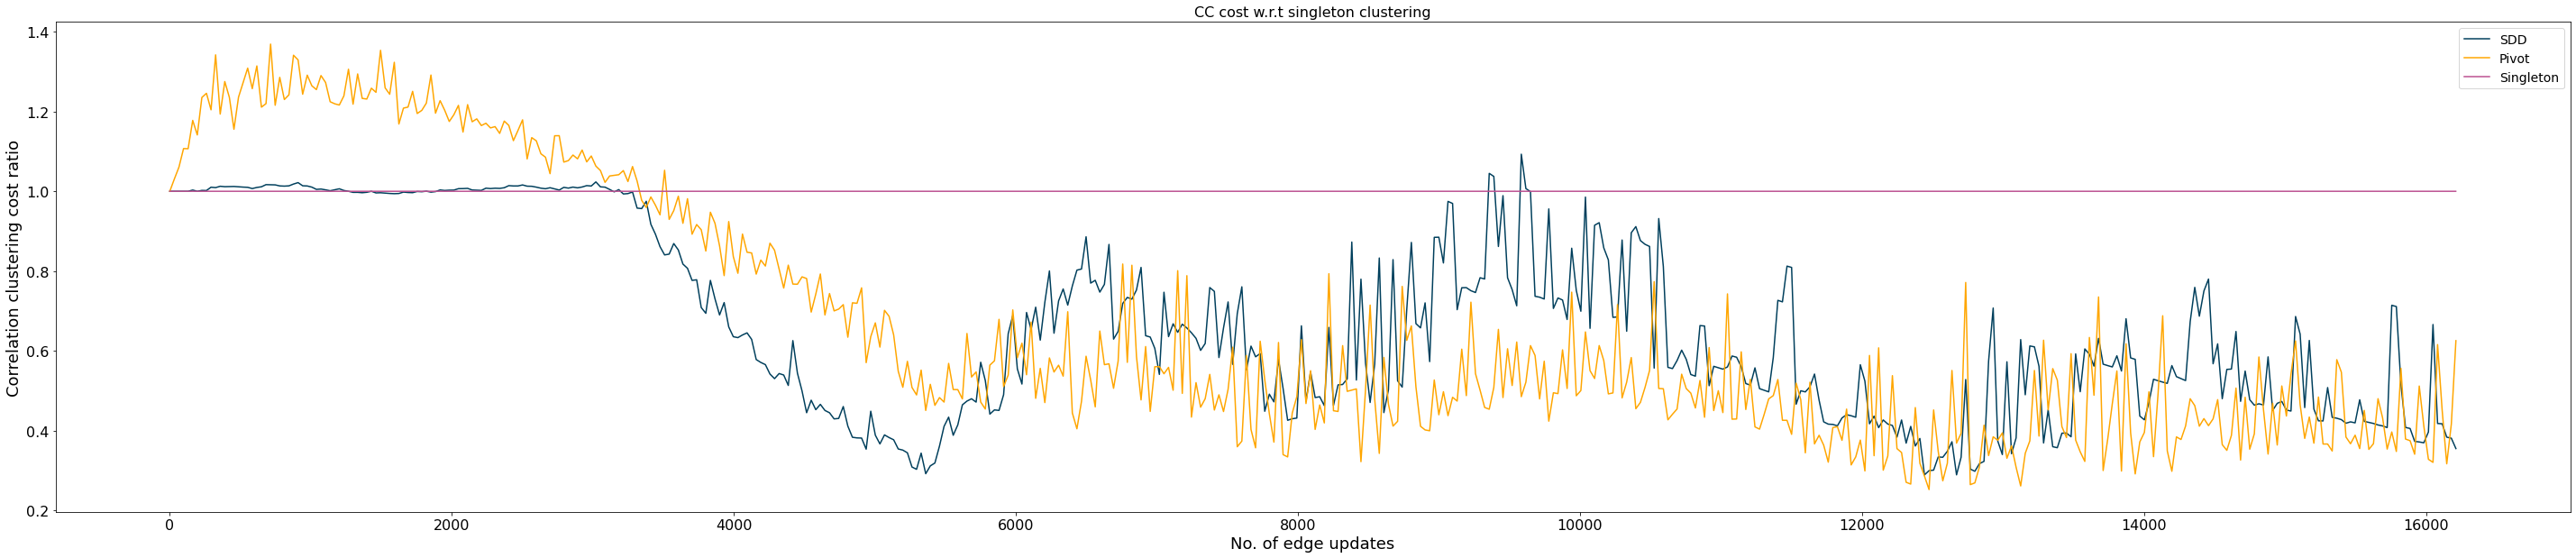

In [20]:
'''
For smoother plots
'''

colors = ["#003f5c","#ffa600","#bc5090","#ef5675"]


#plt.xlim(0,15000)
#plt.ylim(0,1)

stream_length = len(SDD_cost) #Stream length is different from the set value because deletions are separate

pivot_spline = make_interp_spline(range(stream_length), np.array(pivot_cost)/singleton_cost)

pivot_x = np.linspace(0, stream_length, 500)
pivot_smoothed_cost = pivot_spline(pivot_x)

sdd_spline = make_interp_spline(range(stream_length), np.array(SDD_cost)/singleton_cost)

sdd_x = np.linspace(0, stream_length, 500)
sdd_smoothed_cost = sdd_spline(sdd_x)

plt.figure(figsize=(50, 10))



plt.plot(sdd_x, sdd_smoothed_cost, c=colors[0], label="SDD")
plt.plot(pivot_x, pivot_smoothed_cost, c=colors[1], label="Pivot")
plt.plot(range(stream_length), np.array(singleton_cost)/singleton_cost, c=colors[2], label="Singleton")

plt.xlabel("No. of edge updates",fontsize=18)
plt.ylabel("Correlation clustering cost ratio",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title(r"Intersecting circles: $\epsilon=0.25, q()=\ell_2$")
plt.title("CC cost w.r.t singleton clustering",fontsize=16)
plt.legend(fontsize=14)
plt.show()

#plt.savefig("figures/sbm_cost_adv.pdf", bbox_inches='tight', dpi=400)



For of clustering is dict[vertex-name]: cluster-name

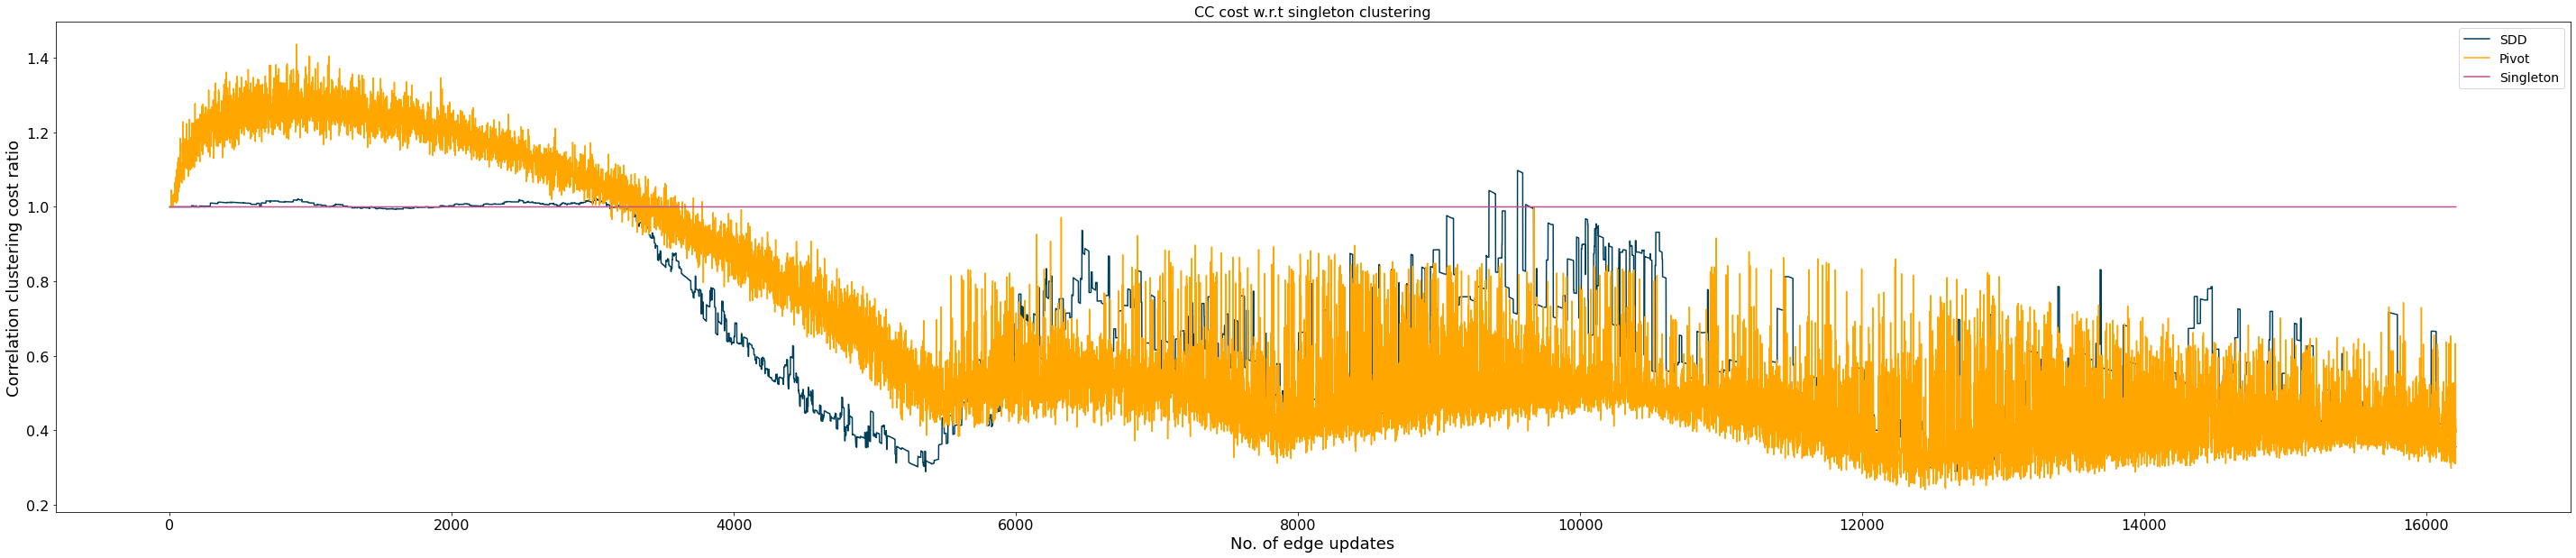

In [21]:
'''
For not so smooth plots.....
'''


colors = ["#003f5c","#ffa600","#bc5090","#ef5675"]


#plt.xlim(0,15000)
#plt.ylim(0,1)

plt.figure(figsize=(50, 10))

stream_length = len(SDD_cost) #Stream length is different from the set value because deletions are separate

plt.plot(range(stream_length), np.array(SDD_cost)/singleton_cost, c=colors[0], label="SDD")
plt.plot(range(stream_length), np.array(pivot_cost)/singleton_cost, c=colors[1], label="Pivot")
plt.plot(range(stream_length), np.array(singleton_cost)/singleton_cost, c=colors[2], label="Singleton")

plt.xlabel("No. of edge updates",fontsize=18)
plt.ylabel("Correlation clustering cost ratio",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title(r"Intersecting circles: $\epsilon=0.25, q()=\ell_2$")
plt.title("CC cost w.r.t singleton clustering",fontsize=16)
plt.legend(fontsize=14)
plt.show()

#plt.savefig("figures/sbm_cost.pdf", bbox_inches='tight', dpi=400)


In [22]:
amortized_SDD_time = []
amortized_pivot_time = []

start_idx = 0

#Update times till the update that triggers SDD recomputation
for end_idx in np.nonzero(SDD_time)[0]:
    #Check if last update
    if end_idx < len(SDD_time):
        SDD_update_times   = SDD_time[end_idx:]
        pivot_update_times = pivot_time[end_idx:]
        amortized_SDD_time.append(np.mean(SDD_update_times))
        amortized_pivot_time.append(np.mean(pivot_update_times))
    else:
        SDD_update_times   = SDD_time[start_idx:end_idx]
        pivot_update_times = pivot_time[start_idx:end_idx]
        amortized_SDD_time.append(np.mean(SDD_update_times))
        amortized_pivot_time.append(np.mean(pivot_update_times))
        start_idx = end_idx

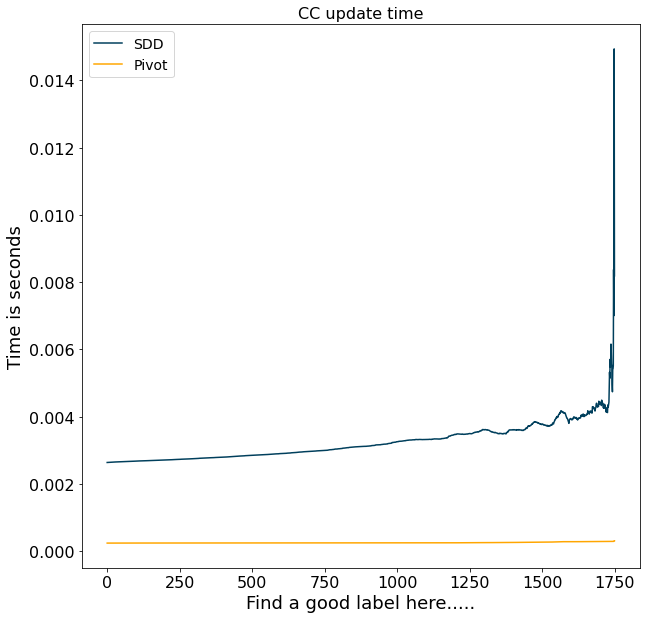

In [23]:
colors = ["#003f5c","#ffa600","#bc5090","#ef5675"]

'''
Something fishy with the last update.....
'''

#plt.xlim(0,15000)
#plt.ylim(0,1)

plt.figure(figsize=(10, 10))

stream_length = len(amortized_SDD_time) #Stream length is different from the set value because deletions are separate

plt.plot(range(stream_length), amortized_SDD_time, c=colors[0], label="SDD")
plt.plot(range(stream_length), amortized_pivot_time, c=colors[1], label="Pivot")

plt.xlabel("Find a good label here.....",fontsize=18)
plt.ylabel("Time is seconds",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title(r"Intersecting circles: $\epsilon=0.25, q()=\ell_2$")
plt.title("CC update time",fontsize=16)
plt.legend(fontsize=14)
plt.show()